In [1]:
from torchinfo import summary
import torch
import mlflow
import mlflow.pytorch
import os
# connect the experiment to the tracking server
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# set the experiment name
mlflow.set_experiment("SPAD-UNet-model")

# enable autologging
mlflow.pytorch.autolog()


In [2]:
# Set up logging to a file
import logging

# Get current working directory
log_file_path = os.path.join(os.getcwd(), 'training.log')

# Set up the logger manually
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Remove all previous handlers (important in Jupyter)
logger.handlers.clear()

# Create and add FileHandler
file_handler = logging.FileHandler(log_file_path, mode='w')
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Optional: also log to console
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

In [3]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    """
    Set the seed for reproducibility in PyTorch, NumPy, and Python's random module.
    Ensures deterministic behavior on CPU, CUDA, and MPS.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # Works for CPU & MPS

    if torch.backends.mps.is_available():
        logging.info("MPS backend is available. It uses the global PyTorch seed.")

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # Multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    torch.use_deterministic_algorithms(True, warn_only=True)
    logging.info("Deterministic algorithms set to True.")
    logging.info("Random seed set to: %d", seed)

# Example usage
global_seed = 42
set_seed(global_seed)

2025-04-06 23:37:09,118 - INFO - MPS backend is available. It uses the global PyTorch seed.
2025-04-06 23:37:09,119 - INFO - Deterministic algorithms set to True.
2025-04-06 23:37:09,119 - INFO - Random seed set to: 42


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class SPAD_DATASET(Dataset):
    def __init__(self, image_dir, depth_dir, transform=None, depth_transform=None):
        """
        Custom dataloader for SPAD binary png images dataset.

        Args:
            image_dir (str): Path to image directory (train, val, test).
            depth_dir (str): Path to corresponding depth map directory.
            transform (callable, optional): Transformations for images.
            edge_transform (callable, optional): Transformations for edge maps.
        """
        self.image_dir = image_dir
        self.depth_dir = depth_dir
        self.transform = transform
        self.depth_transform = depth_transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)

        # Load Ground Truth depth Image
        depth_path = os.path.join(self.depth_dir, img_name)
        depth_image = Image.open(depth_path).convert('L')

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.depth_transform:
            depth_image = self.depth_transform(depth_image)

        return image, depth_image

# Separate transforms
input_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

depth_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

g = torch.Generator()
g.manual_seed(42)

# Create Dataloaders
dataloader_train_batch = 16
dataloader_eval_batch = 4

train_dataset = SPAD_DATASET(image_dir='competition-data/training-images', depth_dir='competition-data/training-depths',
                         transform=input_transform, depth_transform=depth_transform)
train_loader = DataLoader(train_dataset, batch_size=dataloader_train_batch, shuffle=False, num_workers=0, generator=g)

val_dataset = SPAD_DATASET(image_dir='competition-data/validation-images', depth_dir='competition-data/validation-depths',
                       transform=input_transform, depth_transform=depth_transform)
val_loader = DataLoader(val_dataset, batch_size=dataloader_eval_batch, shuffle=False, num_workers=0, generator=g)

In [5]:
class SPAD_DATASET_test(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Custom dataloader for SPAD binary png images dataset.

        Args:
            image_dir (str): Path to image directory (train, val, test).
            depth_dir (str): Path to corresponding depth map directory.
            transform (callable, optional): Transformations for images.
            edge_transform (callable, optional): Transformations for edge maps.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, img_name
    
# Create Dataloaders for test dataset
test_dataset = SPAD_DATASET_test(image_dir='competition-data/testing-images', transform=input_transform)
test_loader = DataLoader(test_dataset, batch_size=dataloader_eval_batch, shuffle=False, num_workers=0, generator=g)

In [6]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, base_c= 16, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        self.encoder_conv_1 = self.conv_block(in_channels, base_c)
        self.encoder_conv_2 = self.conv_block(base_c, base_c*2)
        self.encoder_conv_3 = self.conv_block(base_c*2, base_c*4)
        self.encoder_conv_4 = self.conv_block(base_c*4, base_c*8)
        self.bottleneck = self.conv_block(base_c*8, base_c*16)

        self.upconv4 = nn.ConvTranspose2d(base_c*16, base_c*8, 2, 2)
        self.upconv3 = nn.ConvTranspose2d(base_c*8, base_c*4, 2, 2)
        self.upconv2 = nn.ConvTranspose2d(base_c*4, base_c*2, 2, 2)
        self.upconv1 = nn.ConvTranspose2d(base_c*2, base_c, 2, 2)

        self.decoder_conv_4 = self.conv_block(base_c*16, base_c*8)
        self.decoder_conv_3 = self.conv_block(base_c*8, base_c*4)
        self.decoder_conv_2 = self.conv_block(base_c*4, base_c*2)
        self.decoder_conv_1 = self.conv_block(base_c*2, base_c)

        self.final = nn.Conv2d(base_c, out_channels, 1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )

    def downsample(self, x):
        return nn.MaxPool2d(kernel_size=2, stride=2)(x)

    def upsample(self, x):
        return nn.ConvTranspose2d(x.size(1), x.size(1) // 2, kernel_size=2, stride=2)(x)

    def forward(self, x):
        # Encoder
        enc_1 = self.encoder_conv_1(x)
        down_1 = self.downsample(enc_1)

        enc_2 = self.encoder_conv_2(down_1)
        down_2 = self.downsample(enc_2)

        enc_3 = self.encoder_conv_3(down_2)
        down_3 = self.downsample(enc_3)

        enc_4 = self.encoder_conv_4(down_3)
        down_4 = self.downsample(enc_4)


        # Bottleneck
        bottleneck = self.bottleneck(down_4)


        # Decoder
        up_4 = self.upconv4(bottleneck)
        skip_conn_4 = torch.cat((up_4, enc_4), dim=1)
        dec_4 = self.decoder_conv_4(skip_conn_4)

        up_3 = self.upconv3(dec_4)
        skip_conn_3 = torch.cat((up_3, enc_3), dim=1)
        dec_3 = self.decoder_conv_3(skip_conn_3)

        up_2 = self.upconv2(dec_3)
        skip_conn_2 = torch.cat((up_2, enc_2), dim=1)
        dec_2 = self.decoder_conv_2(skip_conn_2)

        up_1 = self.upconv1(dec_2)
        skip_conn_1 = torch.cat((up_1, enc_1), dim=1)
        dec_1 = self.decoder_conv_1(skip_conn_1)

        # Final output
        output = self.final(dec_1)

        return output


In [7]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    epoch_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    mlflow.log_metric("train_loss", epoch_loss / len(train_loader), step=epoch+1)
    logging.info(f"Epoch {epoch+1}: Train Loss = {epoch_loss / len(train_loader)}")

def validate(model, val_loader, criterion, device, epoch):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    # Calculate MSE 
    mse = total_loss / len(val_loader)
    # RMSE calculation
    rmse = mse**0.5
    # Log metrics
    logging.info(f"Epoch {epoch+1} - Val Loss (MSE): {mse}, RMSE: {rmse}")
    mlflow.log_metric("val_loss", mse, step=epoch)
    mlflow.log_metric("val_RMSE", rmse, step=epoch)
    
    return rmse


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_score is None or val_loss < self.best_score - self.min_delta:
            self.best_score = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()
            if self.verbose:
                logging.info(f"Monitored metric improved to {val_loss:.6f}")
        else:
            self.counter += 1
            if self.verbose:
                logging.info(f"Monitored metric did not improve. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    logging.warning("Early stopping triggered.")

In [9]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Initialize model
base_c = 32
model = UNet(base_c=base_c)


# Iniitialize criterion
criterion = nn.MSELoss()


# Initialize optimizer
starting_lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=starting_lr)


# Initialize learning rate scheduler
scheduler_mode = 'min'
scheduler_factor = 0.5
scheduler_patience = 3
scheduler_cooldown = 2
scheduler_min_lr = 1e-6
scheduler_threshold = 0.001
scheduler_threshold_mode = 'abs'

scheduler = ReduceLROnPlateau(optimizer, mode=scheduler_mode,
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              cooldown=scheduler_cooldown,
                              min_lr=scheduler_min_lr,
                              threshold=scheduler_threshold,
                              threshold_mode=scheduler_threshold_mode,
                              verbose=True)

# Initialize early stopping
early_stopping_patience = scheduler_cooldown + scheduler_patience + 2
early_stopping_delta = scheduler_threshold/2
early_stopping = EarlyStopping(patience=early_stopping_patience,
                               verbose=True,
                               min_delta=early_stopping_delta)  # noqa: E501

max_num_epochs = 300

# Check device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
logging.info(f"Using device: {device.type}")
# Move model to device
model.to(device)


# Log params as a dictionary
params = {
    "global_seed": global_seed,
    "train_batch_size": dataloader_train_batch,
    "eval_batch_size": dataloader_eval_batch,
    "base_c": base_c,
    "loss_function": "MSELoss",
    "learning_rate": starting_lr,
    "optimizer": "Adam",
    "scheduler_mode": scheduler_mode,
    "scheduler_factor": scheduler_factor,
    "scheduler_patience": scheduler_patience,
    "scheduler_cooldown": scheduler_cooldown,
    "scheduler_min_lr": scheduler_min_lr,
    "scheduler_therhold": scheduler_threshold,
    "scheduler_threshold_mode": scheduler_threshold_mode,
    "scheduler": "ReduceLROnPlateau",
    "early_stopping_patience": early_stopping_patience,
    "early_stopping_delta": early_stopping_delta,
    "max_epochs": max_num_epochs,
    "device": device.type,
}


/opt/miniconda3/envs/MCV/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2025-04-06 23:37:14,221 - INFO - Using device: mps


In [10]:
# import torch
# model = torch.load("../mlartifacts/243770936088077455/9107bc247a2147b6ab63da8a5c14c2a2/artifacts/models/data/model.pth", weights_only=False)

import os
import torch
from PIL import Image
import torchvision.transforms as transforms

def predict_and_save(model, dataloader, device, output_dir='competition-data/predicted_depths'):
    model.eval()  # Set the model to evaluation mode

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Define the image transformation (optional based on your model)
    transform = transforms.ToPILImage()

    with torch.no_grad():
        for i, (images, filenames) in enumerate(dataloader):  # Assuming filenames are returned along with images
            images = images.to(device)

            # Get the model output
            outputs = model(images)
            outputs = outputs * 0.5 + 0.5  # Denormalize if needed
            outputs = outputs.squeeze(1)  # Assuming single channel output

            for idx in range(len(images)):
                # Convert output to PIL Image and save with same name as input image
                output_img = outputs[idx].cpu()
                output_img = (output_img * 255).clamp(0, 255).byte()  # Convert to uint8

                # Extract original image name
                original_name = filenames[idx]  # Assuming `filenames` contains original names (e.g., list of file names)
                output_path = os.path.join(output_dir, original_name)  # Save using the original name

                # Convert tensor to PIL Image and save
                output_pil = transform(output_img)  # Convert tensor to PIL Image
                output_pil.save(output_path)

                print(f"Saved prediction for image {original_name}")


In [ ]:
# Start MLflow run
with mlflow.start_run():
    ###########################
    # Log the model parameters
    ###########################
    mlflow.log_params(params)
    logging.info("logged params to MLflow")
    logging.info("Starting training...")

    ###########################
    # Training loop
    ###########################
    for epoch in range(max_num_epochs):
        train(model, train_loader, criterion, optimizer, device, epoch)
        rmse = validate(model, val_loader, criterion, device, epoch)
        # Step the scheduler
        scheduler.step(rmse)
        logging.info(f"Epoch {epoch + 1}, LR: {optimizer.param_groups[0]['lr']}")
        # Early stopping check
        early_stopping(rmse, model)
        if early_stopping.early_stop:
            logging.warning("Early stopping triggered. Stopping training.")
            mlflow.log_param("early_stopping_triggered_at", epoch)
            break
    
    ###############################
    # Log the model artifact to run
    ###############################
    mlflow.pytorch.log_model(model, artifact_path="model")
    logging.info("Model logged to MLflow")

    # Get model summary as string
    model_summary = summary(
        model,
        input_size=(1, 1, 256, 256),
        device=device.type 
    )

    # Write to file
    with open("model_report.txt", "w") as f:
        f.write("### MODEL ARCHITECTURE ###\n")
        f.write(str(model))
        f.write("\n\n### MODEL SUMMARY ###\n")
        f.write(str(model_summary))

    mlflow.log_artifact("model_report.txt")
    logging.info("Model report logged to MLflow")

    # test the model and create depth maps
    predict_and_save(model, test_loader, device=device.type, output_dir='competition-data/predicted_depths')

    # run the imgs2csv.py script to create the submission csv file
    os.chdir('competition-data')
    os.system('python imgs2csv.py')

    # Log the artifact from current directory
    mlflow.log_artifact("predictions.csv")

    # go back up to avoid rerun errors
    os.chdir('..')
    logging.info("Predictions CSV logged to MLflow")


2025-04-06 23:37:17,033 - INFO - logged params to MLflow
2025-04-06 23:37:17,034 - INFO - Starting training...
2025-04-06 23:45:42,688 - INFO - Epoch 1: Train Loss = 0.45955253895104786
2025-04-06 23:46:07,374 - INFO - Epoch 1 - Val Loss (MSE): 0.4145762016328328, RMSE: 0.6438759209916401
2025-04-06 23:46:07,418 - INFO - Epoch 0, LR: 0.001
2025-04-06 23:46:07,423 - INFO - Validation loss improved to 0.643876


🏃 View run stately-mink-837 at: http://127.0.0.1:5000/#/experiments/243770936088077455/runs/4043e5382647470291ed567137221efc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/243770936088077455


KeyboardInterrupt: 

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

def plot_results(model, dataloader, device='mps', num_batches=2):
    model.eval()
    batch_count = 0

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(device)
            label = label.unsqueeze(1).to(device)  # Shape: [B, 1, H, W]

            outputs = model(images)               # Shape: [B, 1, H, W]
            outputs = outputs * 0.5 + 0.5         # Denormalize if needed
            outputs = outputs.squeeze(1)          # Shape: [B, H, W]

            for i in range(len(images)):
                pred = outputs[i].cpu()
                # If prediction is float, convert to uint8 in [0, 255]
                pred = (pred * 255).clamp(0, 255).byte()

                pred_img = Image.fromarray(pred.numpy(), mode='L')

                # Plotting
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(label[i].cpu().squeeze(), cmap='gray')
                plt.title("Ground Truth Depth")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_img, cmap='gray')
                plt.title("Predicted Depth")

                plt.show()

            batch_count += 1
            if batch_count >= num_batches:
                break


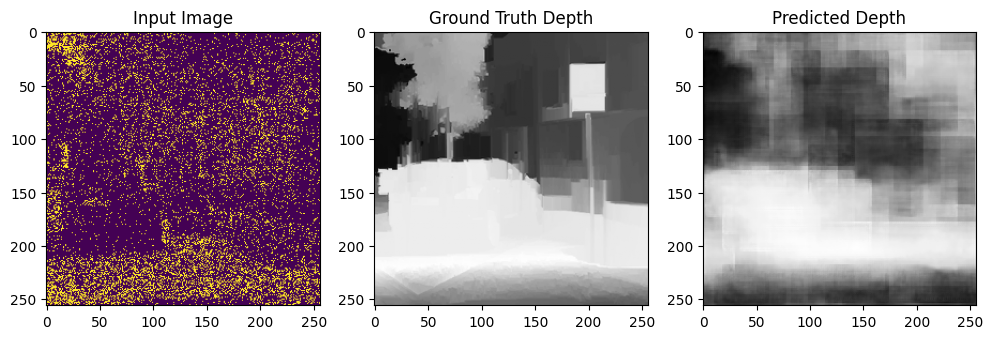

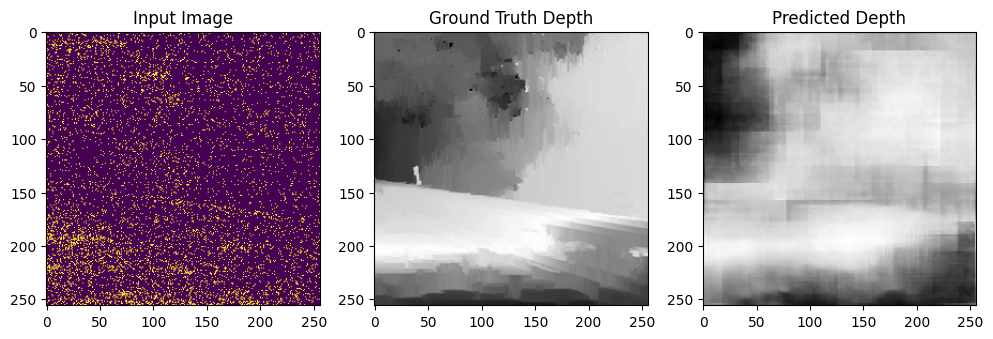

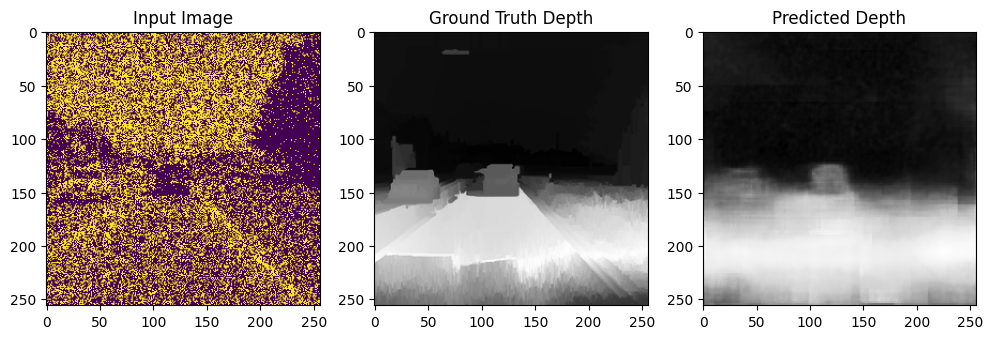

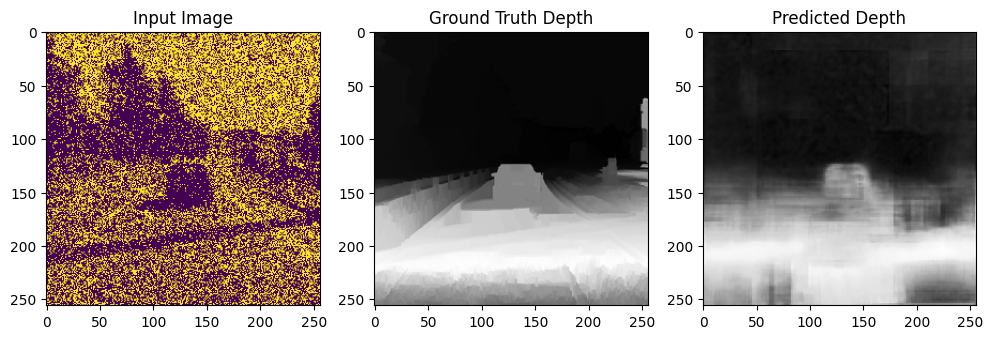

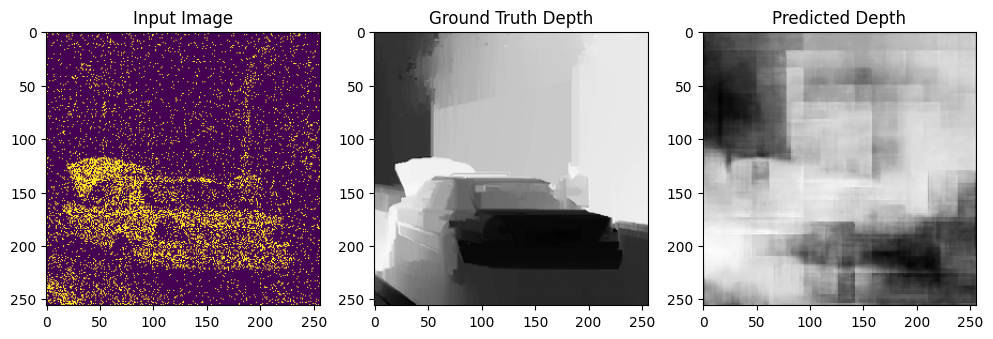

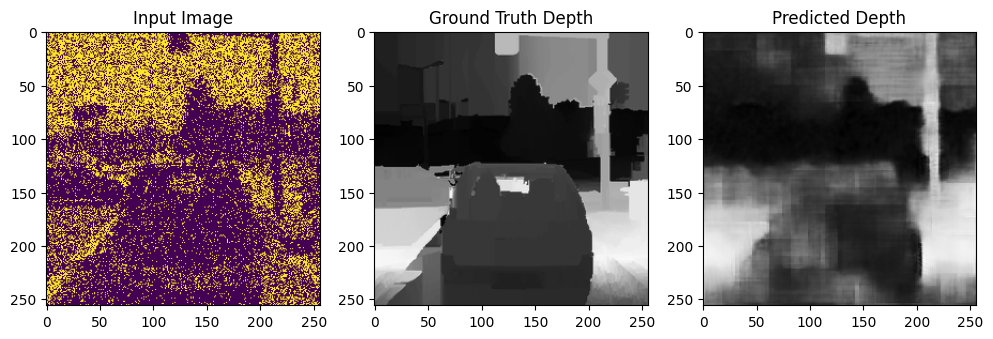

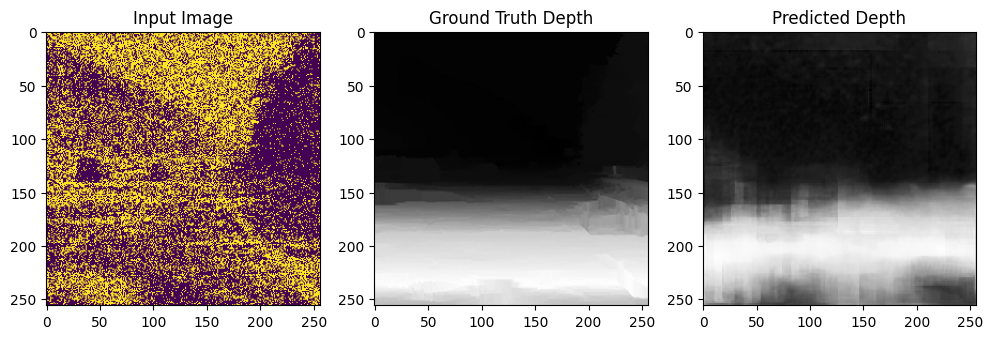

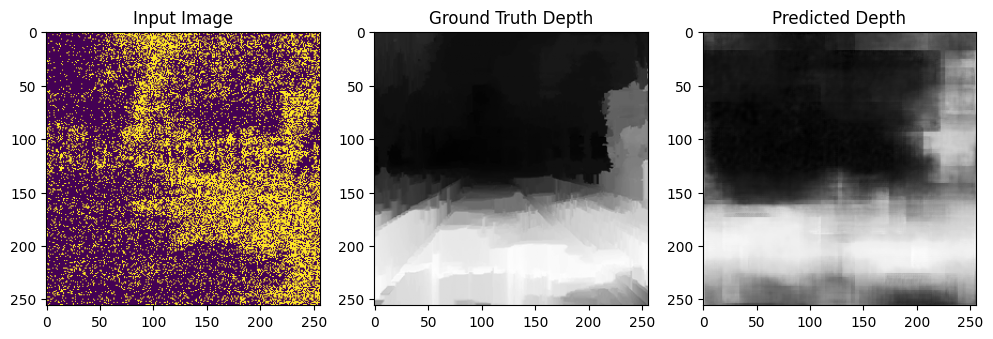

In [16]:
plot_results(model, val_loader, device='mps', num_batches=2)

In [10]:
for epoch in range(20):
    rmse = 1.0  # simulate plateau
    scheduler.step(rmse)
    print(f"Epoch {epoch}, LR: {optimizer.param_groups[0]['lr']}")


Epoch 0, LR: 0.001
Epoch 1, LR: 0.001
Epoch 2, LR: 0.001
Epoch 3, LR: 0.001
Epoch 4, LR: 0.0005
Epoch 5, LR: 0.0005
Epoch 6, LR: 0.0005
Epoch 7, LR: 0.0005
Epoch 8, LR: 0.0005
Epoch 9, LR: 0.0005
Epoch 10, LR: 0.00025
Epoch 11, LR: 0.00025
Epoch 12, LR: 0.00025
Epoch 13, LR: 0.00025
Epoch 14, LR: 0.00025
Epoch 15, LR: 0.00025
Epoch 16, LR: 0.000125
Epoch 17, LR: 0.000125
Epoch 18, LR: 0.000125
Epoch 19, LR: 0.000125
